<a href="https://colab.research.google.com/github/rubanzasilva/abalone_age_prediction/blob/dev/ps_s04e04_fastai_exp2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Abalone Age Prediction

Predicting the age of abalone from physical measurements.  The age of abalone is determined by cutting the shell through the cone, staining it, and counting the number of rings through a microscope -- a boring and time-consuming task.  Other measurements, which are easier to obtain, are used to predict the age.  Further information, such as weather patterns and location (hence food availability) may be required to solve the problem.

From the original data examples with missing values were removed (the majority having the predicted value missing), and the ranges of the continuous values have been scaled for use with an ANN (by dividing by 200).

### Imports

In [2]:
!pip install catboost
!pip install fastkaggle

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.2/98.2 MB 7.7 MB/s eta 0:00:00


In [3]:
#hide
#! [ -e /content ]

#hide
#This imports and sets up everything you will need for this notebook
#
#!pip install -Uqq fastbook
#import fastbook
#fastbook.setup_book()

#from fastbook import *
#!pip install ucimlrepo
#from ucimlrepo import fetch_ucirepo

from fastai.tabular.all import *
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from numpy import random

from fastai.imports import *
np.set_printoptions(linewidth=130)


from pathlib import Path
import os


from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
#from sklearn.metrics import root_mean_squared_error

import xgboost as xgb
from xgboost import plot_importance

import lightgbm as lgb

from catboost import CatBoostClassifier,CatBoostRegressor,Pool, metrics, cv

from ipywidgets import interact


matplotlib.rc('image', cmap='Greys')

from fastkaggle import setup_comp

In [5]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"rubanzasilva","key":"3c109650146efc9c92fc9e8bfe70d487"}'}

In [6]:
! mkdir ~/.kaggle

! cp kaggle.json ~/.kaggle/

#chmod 600 /root/.kaggle/kaggle.json

In [4]:
!ls

sample_data


In [7]:
comp = 'playground-series-s4e4'

path = setup_comp(comp, install='fastai "timm>=0.6.2.dev0"')

100%|██████████| 2.41M/2.41M [00:00<00:00, 175MB/s]

In [8]:
path

Path('playground-series-s4e4')

In [9]:
!ls playground-series-s4e4

sample_submission.csv  test.csv  train.csv


In [ ]:
#set_seed(42)

In [13]:
path = Path('playground-series-s4e4/')
path

Path('playground-series-s4e4')

### Index_col

Removing the id column seems to slightly improve predictions so i go with a dataset with the id column set as the index.

We manually import the original dataset via upload or we can mount gdrive and get the abalone dataset i have stored in my google drive datasets folder.This csv dataset was downloaded from kaggle datasets created by another user located https://www.kaggle.com/code/aaachen/ps4e4-xgboost-lightgbm-catboost/input?select=abalone.csv as the file is already a csv. I shall try to manually import it from UCI later on.

Another way would be to import the original dataset from the UC Irvine Machine Learning Repository into kaggle using their ucimlrepo package.



In [ ]:
#from google.colab import drive
#drive.mount('/content/drive')

In [14]:
train_df = pd.read_csv(path/'train.csv',index_col='id')
test_df = pd.read_csv(path/'test.csv',index_col='id')
sub_df = pd.read_csv(path/'sample_submission.csv',index_col='id')
original_df = pd.read_csv(path/'abalone.csv')

In [ ]:
#train_df = pd.read_csv(path/'train.csv')
#test_df = pd.read_csv(path/'test.csv')
#sub_df = pd.read_csv(path/'sample_submission.csv')
#original_df = pd.read_csv(path/'abalone.csv')

In [ ]:
#train_df = train_df.drop("id", axis=1)
#test_df = test_df.drop("id", axis=1)

To include the original dataset, i have two approaches

First one, i add id as the index of the original and then join/concat on id, then see if this improves results.

Second, i drop id from train_df and concat on axis 0 adding new rows to the dataset, then test the effect on the results.

In [10]:
original_df.shape,train_df.shape

((4177, 9), (90615, 9))

In [15]:
original_df.index.name = 'id'
#test.index.name = 'id'

In [14]:
train_df.columns,original_df.columns

(Index(['Sex', 'Length', 'Diameter', 'Height', 'Whole weight', 'Whole weight.1',
        'Whole weight.2', 'Shell weight', 'Rings'],
       dtype='object'),
 Index(['Sex', 'Length', 'Diameter', 'Height', 'Whole weight', 'Shucked weight',
        'Viscera weight', 'Shell weight', 'Rings'],
       dtype='object'))

In [16]:
original_df = original_df.rename(columns={'Shucked weight':'Whole weight.1', 'Viscera weight':'Whole weight.2'})

In [14]:
#train.index.name = 'id'
#test.index.name = 'id'

In [17]:
train_df = pd.concat([train_df,original_df], axis=0)
train_df.shape
#final_test = pd.concat([test_df,test], axis=0)
#sub

(94792, 9)

In [17]:
test_df.shape, train_df.shape

((60411, 8), (94792, 9))

Import the original dataset from the UC Irvine Machine Learning Repository into kaggle using their ucimlrepo package.

In [ ]:
# fetch dataset
#abalone = fetch_ucirepo(id=1)

#path = playground-series-s4e4/abalone

#original_df = pd.read_csv(path,index_col='id')

#original_df = pd.DataFrame(abalone['data'], columns=abalone['names'])
#original_df.index.rename('id', inplace=True)


I import the abalone dataset from https://www.kaggle.com/code/aaachen/ps4e4-xgboost-lightgbm-catboost/input?select=abalone.csv as the file is already a csv. I shall try to manually import it from UCI later on.

# Model Architectures.

Below, i try out various models.

I have combined the steps for the different models in one codecell respectively, to see the breakdown, go through the breakdown section

In [18]:
cont_names,cat_names = cont_cat_split(train_df, dep_var='Rings')
splits = RandomSplitter(valid_pct=0.2)(range_of(train_df))
to = TabularPandas(train_df, procs=[Categorify, FillMissing,Normalize],
                   cat_names = cat_names,
                   cont_names = cont_names,
                   y_names='Rings',
                   y_block=RegressionBlock(),
                   splits=splits)

X_train, y_train = to.train.xs, to.train.ys.values.ravel()
X_test, y_test = to.valid.xs, to.valid.ys.values.ravel()

In [19]:
dls = to.dataloaders(bs=64)
test_dl = dls.test_dl(test_df)

In [26]:
dls.xs

,Sex,Length,Diameter,Height,Whole weight,Whole weight.1,Whole weight.2,Shell weight
id,,,,,,,,
82960,2,-1.076975,-1.141335,-0.932412,-1.236657,-1.217845,-1.196757,-1.082266
59562,3,0.741800,0.746647,0.639410,0.929859,0.996352,0.757713,0.636788
66935,1,-0.146439,0.032275,-0.277486,-0.330402,-0.325338,-0.278749,-0.125109
82285,1,1.333959,1.256912,1.425321,1.675995,1.942507,1.863273,1.444628
87507,3,0.572611,0.542541,0.246454,0.515945,0.411102,0.417162,0.449185
...,...,...,...,...,...,...,...,...
13161,2,0.572611,0.491514,0.377440,0.124904,0.028250,0.012448,-0.010250
46021,2,-1.246163,-1.243389,-1.194382,-1.252996,-1.232477,-1.107918,-1.273698
8846,2,0.022749,0.287408,0.901380,-0.170282,-0.418003,-0.160296,0.066322


In [37]:
#dls.ys

In [38]:
#test_dl.xs

# Neural Network

SuggestedLRs(slide=6.309573450380412e-07, valley=0.009120108559727669)

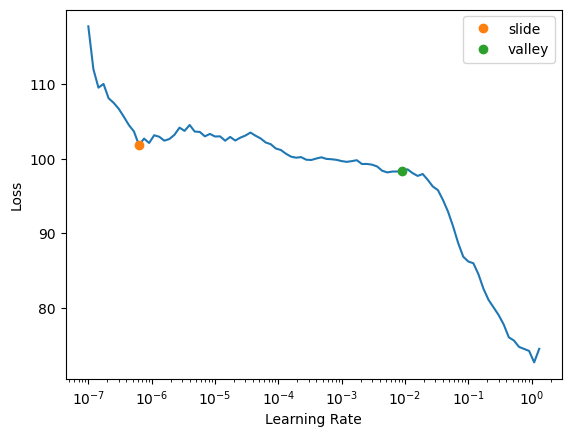

In [21]:
#dls = to.dataloaders(bs=64)
#test_dl = dls.test_dl(test_df)

learn = tabular_learner(dls, metrics=rmse)
learn.lr_find(suggest_funcs=(slide,valley))

## Neural Network Ensemble

The Neural network ensemble results in slighty better results.

In [22]:
learn.fit_one_cycle(10,0.005)
dl = learn.dls.test_dl(test_df)
nn_preds = learn.get_preds(dl=dl)
nn_preds_x = learn.get_preds()[0]
a_preds, _ = learn.get_preds(dl=dl)
nn_preds_y = a_preds.squeeze(1)

mse = mean_absolute_error(y_test, nn_preds_x)
rmse = np.sqrt(mse)
rmse

epoch,train_loss,valid_loss,_rmse,time
0,3.971921,3.880967,1.970017,00:09
1,3.851186,3.730005,1.931322,00:09
2,4.041251,4.085020,2.021143,00:09
3,4.014867,3.615006,1.901317,00:09
4,3.771603,3.585919,1.893652,00:10
5,3.961274,3.504535,1.872040,00:09
6,3.621173,3.518008,1.875635,00:09
7,3.674019,3.507391,1.872803,00:11
8,3.757279,3.484577,1.866702,00:09
9,3.614006,3.484039,1.866558,00:09


1.1278783

In [43]:
nn_preds_x.shape,nn_preds_y.shape

NameError: name 'nn_preds_x' is not defined

In [ ]:
dl = learn.dls.test_dl(test_df)
def ensemble():
  learn = tabular_learner(dls, metrics=mae)
  with learn.no_bar(), learn.no_logging():
    learn.fit(12, 0.006)
  return learn.get_preds(dl=dl)[0]

learns = [ensemble() for _ in range(5)]

In [ ]:
ens_preds = torch.stack(learns).mean(0)

In [ ]:
ens_preds_x = ens_preds.squeeze(1)
ens_preds_x.shape

torch.Size([60411])

In [ ]:
#target_preds = nn_preds[0]

#test_df['Rings'] = target_preds

#test_df.to_csv('submission.csv', columns=['Rings'], index=True)

#submission = pd.read_csv('submission.csv')
#submission.head()

In [ ]:
#ens_new = learn.get_preds(dl=dl)
#ens_new_preds, _ = learns.get_preds(dl=dl)
#final_ens_preds = ens_new_preds.squeeze(1)
#final_ens_preds

In [ ]:
#ens_preds = torch.stack(learns).mean(0)
#ens_target_preds = ens_preds
#test_df['Rings'] = ens_target_preds

#test_df.to_csv('submission.csv', columns=['Rings'], index=True)

#submission = pd.read_csv('submission.csv')
#submission.head()

In [ ]:
#mse = mean_absolute_error(y_test, ens_preds_y)
#rmse = np.sqrt(mse)
#rmse

## GBM'S

The GBMS'S basically have the same structure

define the regressor and the params, fit the model on the dataset, get predictions and return the rmse score.

# CATBOOST

In [30]:
#best_cat_params = study_catboost.best_trial
print(study_catboost.best_params)

{'learning_rate': 0.2222399612038645, 'depth': 7, 'random_strength': 5}


In [65]:
#with optuna params
cat_model = CatBoostRegressor(iterations=500, depth=7, learning_rate= 0.2222399612038645, random_strength=5)
cat_model = cat_model.fit(X_train, y_train, eval_set=(X_test, y_test), verbose=False)

#test set preds
cat_preds = tensor(cat_model.predict(test_dl.xs))

#validation set preds
cat_preds_x = tensor(cat_model.predict(X_test))

mse = mean_absolute_error(y_test, cat_preds_x)
rmse = np.sqrt(mse)
rmse

1.1177026

# XGBoost

In [41]:
#best_xgboost_params = study_xgboost.best_trial
print(study_xgboost.best_params)

{'n_estimators': 187, 'max_depth': 8, 'learning_rate': 0.046018206875864616, 'subsample': 0.7091172175235119}


In [64]:
xgb_model = xgb.XGBRegressor(n_estimators = 187, max_depth=8, learning_rate=0.046018206875864616, subsample=0.7091172175235119)
xgb_model = xgb_model.fit(X_train, y_train)

xgb_preds = tensor(model.predict(test_dl.xs))

xgb_preds_x = tensor(xgb_model.predict(X_test))
mse = mean_absolute_error(y_test, model.predict(X_test))
rmse = np.sqrt(mse)
rmse

1.1173751

# LightGBM

In [46]:
#best_lgb_params = study_lgbm.best_trial
print(study_lgbm.best_params)

{'num_leaves': 47, 'learning_rate': 0.19470589857022183, 'n_estimators': 165}


In [63]:
lgb_model = lgb.LGBMRegressor(num_leaves=47, learning_rate=0.19470589857022183, n_estimators=165)
lgb_model = lgb_model.fit(X_train, y_train)

#test set preds
lgb_preds = tensor(new_model.predict(test_dl.xs))

#validation set preds
lgb_preds_x = tensor(lgb_model.predict(X_test))

mse = mean_absolute_error(y_test, lgb_preds_x)
rmse = np.sqrt(mse)
rmse

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005476 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1335
[LightGBM] [Info] Number of data points in the train set: 75834, number of used features: 8
[LightGBM] [Info] Start training from score 9.710130


1.1183631

# Random Forest

In [58]:
rf = RandomForestClassifier(100, min_samples_leaf=5)
rf_model = rf.fit(X_train, y_train);

rf_preds = tensor(rf_model.predict(test_dl.xs))

rf_preds_x = tensor(rf_model.predict(X_test))

mse = mean_absolute_error(y_test, rf_preds_x)
rmse = np.sqrt(mse)
rmse

1.135716183794116

In [66]:
general_preds = ( xgb_preds_x + lgb_preds_x + cat_preds_x +  rf_preds_x )/4
general_preds

tensor([ 8.3351, 13.5001,  5.7440,  ..., 10.7759,  7.7872,  7.0508])

# Hyperparameter Optimization With Optuna


In [ ]:
!pip install optuna

In [ ]:
import optuna
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error

def objective_catboost(trial):
    params = {
        "iterations": 200,
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3, log=True),
        "depth": trial.suggest_int("depth", 1, 10),
        "random_strength": trial.suggest_int("random_strength", 1, 10),
    }
    model = CatBoostRegressor(**params, silent=True)
    model.fit(X_train, y_train, eval_set=(X_test, y_test), verbose=False)
    predictions = model.predict(X_test)
    rmse = mean_squared_error(y_test, predictions, squared=False)
    return rmse

study_catboost = optuna.create_study(direction='minimize')
study_catboost.optimize(objective_catboost, n_trials=100)
print(study_catboost.best_params)

In [ ]:
import xgboost as xgb

def objective_xgboost(trial):
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 100, 200),
        "max_depth": trial.suggest_int("max_depth", 1, 10),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3, log=True),
        "subsample": trial.suggest_float("subsample", 0.1, 1.0),
    }
    model = xgb.XGBRegressor(**params)
    model.fit(X_train, y_train)
    xgb_predictions = model.predict(X_test)
    rmse = mean_squared_error(y_test, xgb_predictions, squared=False)
    return rmse

study_xgboost = optuna.create_study(direction='minimize')
study_xgboost.optimize(objective_xgboost, n_trials=100)
print(study_xgboost.best_params)


In [ ]:
import lightgbm as lgb

def objective_lgbm(trial):
    params = {
        "num_leaves": trial.suggest_int("num_leaves", 20, 50),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3, log=True),
        "n_estimators": trial.suggest_int("n_estimators", 100, 200),
    }
    model = lgb.LGBMRegressor(**params)
    model.fit(X_train, y_train)
    lgb_predictions = model.predict(X_test)
    rmse = mean_squared_error(y_test, lgb_predictions, squared=False)
    return rmse

study_lgbm = optuna.create_study(direction='minimize')
study_lgbm.optimize(objective_lgbm, n_trials=100)
print(study_lgbm.best_params)


In [55]:
general_preds = ( xgb_preds + lgb_preds + cat_preds + nn_preds_x + rf_preds )/5
general_preds

tensor([[ 9.3668,  9.1291,  9.3797,  ..., 11.3689, 11.8559,  8.0991],
        [10.0564,  9.8188, 10.0693,  ..., 12.0586, 12.5455,  8.7887],
        [10.1867,  9.9490, 10.1996,  ..., 12.1888, 12.6758,  8.9190],
        ...,
        [11.3533, 11.1157, 11.3663,  ..., 13.3555, 13.8424, 10.0856],
        [ 9.8365,  9.5989,  9.8495,  ..., 11.8387, 12.3256,  8.5688],
        [ 9.6902,  9.4526,  9.7032,  ..., 11.6924, 12.1793,  8.4225]])

In [50]:
xgb_preds.shape,lgb_preds.shape,cat_preds.shape,rf_preds.shape,nn_preds_y.shape

(torch.Size([60411]),
 torch.Size([60411]),
 torch.Size([60411]),
 torch.Size([60411]),
 torch.Size([60411]))

In [ ]:
lgb_preds.shape,xgb_preds.shape,cat_preds.shape,rf_preds.shape,nn_preds_y.shape,ens_preds_x.shape

(torch.Size([60411]),
 torch.Size([60411]),
 torch.Size([60411]),
 torch.Size([60411]),
 torch.Size([60411]),
 torch.Size([60411]))

In [ ]:
general_preds = ( xgb_preds + lgb_preds + cat_preds + rf_preds )/4
general_preds

tensor([ 9.4758,  9.5785,  9.9350,  ..., 12.1424, 13.3392,  8.2579])

In [ ]:
general_preds

tensor([ 9.4758,  9.5785,  9.9350,  ..., 12.1424, 13.3392,  8.2579])

In [60]:
general_preds.shape

torch.Size([60411])

In [58]:
nn_preds_y.shape

torch.Size([60411])

In [59]:
general_preds = ( xgb_preds + lgb_preds + cat_preds + nn_preds_y + rf_preds)/5
general_preds

tensor([ 9.4925,  9.7837,  9.8900,  ..., 12.3405, 13.5124,  8.2287])

In [64]:
general_preds = ( xgb_preds + lgb_preds + cat_preds )/ 3
general_preds

tensor([ 9.6031,  9.7504, 10.0857,  ..., 12.9301, 13.7914,  8.5026])

In [65]:
!ls

 catboost_info	    kaggle.json   playground-series-s4e4       sample_data
'kaggle (1).json'   models	  playground-series-s4e4.zip   submission.csv


In [66]:
!rm submission.csv

In [67]:
!ls

 catboost_info	    kaggle.json   playground-series-s4e4       sample_data
'kaggle (1).json'   models	  playground-series-s4e4.zip


Find a way to test different variations of general_preds before kaggle submission.

# Submission

In [69]:
submit = pd.read_csv(path/'sample_submission.csv')
submit['Rings'] = general_preds
submit.to_csv('submission.csv', index=False)
sub = pd.read_csv('submission.csv')
sub

,id,Rings
0,90615,9.603080
1,90616,9.750393
2,90617,10.085736
3,90618,10.491308
4,90619,7.572184
...,...,...
60406,151021,6.487994
60407,151022,9.665089
60408,151023,12.930064
60409,151024,13.791417


In [70]:
!kaggle competitions submit -c playground-series-s4e4 -f submission.csv -m "optuna + adding original dataset without dropping id, where id is the index for both datasets + xgb_preds + lgb_preds + cat_preds while removing rf_preds + nn_preds_y"

100% 963k/963k [00:00<00:00, 1.45MB/s]
Successfully submitted to Regression with an Abalone Dataset

In [1]:
general_preds.shape

NameError: name 'general_preds' is not defined

In [ ]:
mse = mean_absolute_error(y_test, general_preds)
rmse = np.sqrt(mse)
rmse

In [ ]:
!ls

catboost_info  models  submission.csv


# Acknowledgements

https://www.kaggle.com/code/aaachen/ps4e4-xgboost-lightgbm-catboost/notebook



# Breakdown

### Initial Exploratory Data Analysis

**Variable description from the initial UCI dataset repository**

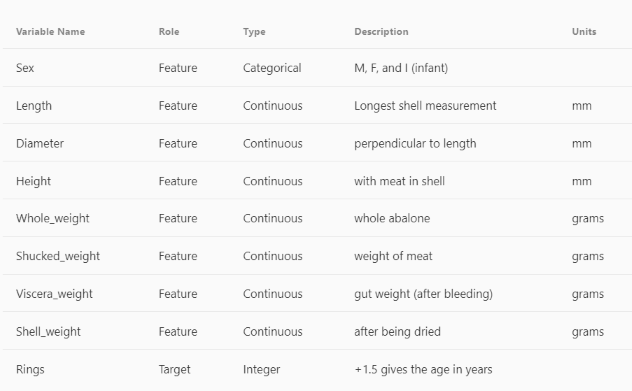


In [ ]:
train_df.head()

Categorical variable exploration

In [ ]:
train_df.describe(include=[object])

In [ ]:
train_df['Sex'].unique()

In [ ]:
train_df['Sex'].hist(figsize=(6,2));

In [ ]:
sex_classes_count = train_df['Sex'].value_counts()
sex_classes_count.plot(kind='pie',figsize=(10,4));

Sex has 3 values ??
Turns out Abalone's sex can change with time or over their lifespans.

The dataset categorises sex into 3 categories i.e. Male, Female and Infant.
We also notice that infant has the most values.

In [ ]:
train_df.describe()

In [ ]:
dep_classes_count = train_df['Rings'].value_counts()
dep_classes_count

In [ ]:
train_df['Rings'].hist()

In [ ]:
dep_classes_count = train_df['Diameter'].value_counts()
dep_classes_count

In [ ]:
train_df['Diameter'].hist()

In [ ]:
dep_classes_count.plot(kind='pie')

In [ ]:
train_df.hist(figsize=(20,15));

#### Feature Engineering

Drop Sex

In [ ]:
!ls

In [ ]:
train_df.drop('Sex', axis=1 , inplace=True)
test_df.drop('Sex', axis=1 , inplace=True)

### TabularPandas Object


We create an instance of a TabularPandas Object,to which is a fastai dataframe wrapper that stores all the information about our dataset such as which columns are continous, categorical, and our dependent variables.

This instance also stores and applies the set transformations to our data.

cont_cat_split helps us split our data into continuos and categorical variables.

In [ ]:
cont_names,cat_names = cont_cat_split(train_df, dep_var='Rings')

We split our data into training and validation with fastai's RandomSplitter which does an 80/20 random split.

In [ ]:
splits = RandomSplitter(valid_pct=0.2)(range_of(train_df))

In [ ]:
to = TabularPandas(train_df, procs=[Categorify, FillMissing,Normalize],
                   cat_names = cat_names,
                   cont_names = cont_names,
                   y_names='Rings',
                   y_block=RegressionBlock(),
                   splits=splits)

In [ ]:
to.xs.iloc[:2]

In [ ]:
dls = to.dataloaders(bs=64)

In [ ]:
dls.show_batch()

In [ ]:
learn = tabular_learner(dls, metrics=rmse)

In [ ]:
learn.lr_find(suggest_funcs=(slide,valley))

In [ ]:
learn.fit_one_cycle(10,0.02)

In [ ]:
#learn.fit_one_cycle(9,0.11)

In [ ]:
learn.show_results()

In [ ]:
dl = learn.dls.test_dl(test_df)

In [ ]:
nn_preds = learn.get_preds(dl=dl)

In [ ]:
a_preds, _ = learn.get_preds(dl=dl)
nn_preds_y = a_preds.squeeze(1)

In [ ]:
nn_preds_x = learn.get_preds()[0]

In [ ]:
X_train, y_train = to.train.xs, to.train.ys.values.ravel()
X_test, y_test = to.valid.xs, to.valid.ys.values.ravel()

In [ ]:
mse = mean_absolute_error(y_test, nn_preds_x)
rmse = np.sqrt(mse)
rmse

In [ ]:
learn = tabular_learner(dls, metrics=rmse)
learn.lr_find(suggest_funcs=(slide,valley))

In [ ]:
#learn.fit_one_cycle(10,0.02)

In [ ]:
mse = mean_absolute_error(y_test, nn_preds_x)
rmse = np.sqrt(mse)
rmse

In [ ]:
#rmse(nn_preds_x, tensor(y_test))

In [ ]:
#rmse(nn_preds_x, tensor(y_test))

In [ ]:
!ls

In [ ]:
#target_preds = nn_preds[0]

In [ ]:
#test_df['Rings'] = target_preds

#test_df.to_csv('submission.csv', columns=['id','Rings'], index=False)

#submission = pd.read_csv('submission.csv')
#submission.head()

In [ ]:
ls

In [ ]:
#!kaggle competitions submit -c playground-series-s4e4 -f submission.csv -m "Neural Network Sub 3 with id column + no random seed "

####Neural Network without id column

In [ ]:
target_preds = nn_preds[0]

test_df['Rings'] = target_preds

test_df.to_csv('submission.csv', columns=['Rings'], index=True, index_label='id')

submission = pd.read_csv('submission.csv')
submission.head()

In [ ]:
!ls

In [ ]:
#!kaggle competitions submit -c playground-series-s4e4 -f submission.csv -m "Neural Network Sub 7 with no id and sex column "

###Neural Network Ensemble

In [ ]:
learn.lr_find(suggest_funcs=(slide,valley))

In [ ]:
dl = learn.dls.test_dl(test_df)

In [ ]:
def ensemble():
    learn = tabular_learner(dls, metrics=accuracy_multi, layers=[20,20,20,20], loss_func = BCEWithLogitsLossFlat())
    with learn.no_bar(),learn.no_logging():
        learn.fit(16, lr=0.07)
        learn.fit_one_cycle(10, slice(0.05, 0.05/5))
    return learn.get_preds(dl=tst_dl)[0]

In [ ]:
def ensemble():
    learn = tabular_learner(dls, metrics=rmse)
    with learn.no_bar(),learn.no_logging(): learn.fit(9, slice(1e-1,1e-3))
    return learn.get_preds(dl=dl)[0]

In [ ]:
#learns = [ensemble() for _ in range(5)]

In [ ]:
ens_preds = torch.stack(learns).mean(0)

In [ ]:
ens_preds, _ = learn.get_preds(dl=dl)

In [ ]:
ens_preds_y = ens_preds.squeeze(1)
ens_preds_y

In [ ]:
mse = mean_absolute_error(y_test, nn_preds_x)
rmse = np.sqrt(mse)
rmse

In [ ]:
ens_preds_y[0]

In [ ]:
#target_preds = ens_preds_y[0]

#test_df['Rings'] = target_preds

#test_df.to_csv('submission.csv', columns=['Rings'], index=True, index_label='id')

#submission = pd.read_csv('submission.csv')
#submission.head()

In [ ]:
target_preds = ens_preds_y

test_df['Rings'] = target_preds

test_df.to_csv('submission.csv', columns=['Rings'], index=True, index_label='id')

submission = pd.read_csv('submission.csv')
submission.head()

In [ ]:
!ls

In [ ]:
!kaggle competitions submit -c playground-series-s4e4 -f submission.csv -m "Neural Network ensemble preds Sub 2 with no id column + no random seed "

In [ ]:
submission = pd.DataFrame({
     # Assuming 'Id' is the identifier column
    'target': ens_preds
})

# Save your submission to a CSV file
submission.to_csv('submission.csv', index=False)

In [ ]:
def subm(preds, suff):
    test_df['Rings'] = preds
    sub_df = test_df[['id','Rings']]
    sub_df.to_csv(f'sub{suff}.csv', index=False)

subm(ens_preds, 'mission')

In [ ]:
#sub_df = pd.DataFrame(ens_preds, columns='Rings')
#sub_df['id'] = test_df['id']

# Reorder the columns to match the submission format
#sub_df = sub_df[['id', 'Pastry', 'Z_Scratch', 'K_Scatch', 'Stains', 'Dirtiness', 'Bumps', 'Other_Faults']]

# Save the submission DataFrame as a CSV file
#sub_df.to_csv('rf_submission.csv', index=False)

In [ ]:
#targets ='Rings'
#test_df[targets] = ens_preds
#sub_df['id'] = test_df['id']

#test_df.to_csv('submission.csv', columns=['Rings'], index=False)

#ens_sub = pd.read_csv('submission.csv')
#ens_sub.head()

### Random Forest

In [ ]:
rf = RandomForestClassifier(100, min_samples_leaf=5)
rf_model = rf.fit(X_train, y_train);

#cont_names,cat_names = cont_cat_split(train_df, dep_var='Rings')
#splits = RandomSplitter(valid_pct=0.2)(range_of(train_df))
#to = TabularPandas(train_df, procs=[Categorify, FillMissing,Normalize],
                  # cat_names = cat_names,
                  # cont_names = cont_names,
                  # y_names='Rings',
                  # y_block=RegressionBlock(),
                  # splits=splits)

#X_train, y_train = to.train.xs, to.train.ys.values.ravel()
#X_test, y_test = to.valid.xs, to.valid.ys.values.ravel()

#dls = to.dataloaders(bs=64)
#test_dl = dls.test_dl(test_df)
#preds = (y_test, rf.predict(X_test))
rf_preds = tensor(rf_model.predict(test_dl.xs))


#submit = pd.read_csv(path/'sample_submission.csv')
#submit['Rings'] = xgb_preds
#submit.to_csv('submission.csv', index=False)
#sub = pd.read_csv('submission.csv')
mse = mean_absolute_error(y_test, rf_model.predict(X_test))
rmse = np.sqrt(mse)
rmse
#mean_absolute_error(y_test, rf.predict(X_test))

In [ ]:
!ls

In [ ]:
X_train, y_train = to.train.xs, to.train.ys.values.ravel()
X_test, y_test = to.valid.xs, to.valid.ys.values.ravel()

In [ ]:
rf = RandomForestClassifier(100, min_samples_leaf=5)
rf.fit(X_train, y_train);
#mean_absolute_error(y_test, rf.predict(X_test))

In [ ]:
mse = mean_absolute_error(y_test, rf.predict(X_test))
rmse = np.sqrt(mse)
rmse

In [ ]:
mse = mean_absolute_error(y_test, nn_preds_x)
rmse = np.sqrt(mse)
rmse

In [ ]:
#rf_preds = rf.predict(X_test)

In [ ]:
#rmse(rf_preds, tensor(y_test))

#### Feature Importance

In [ ]:
def rf_feat_importance(m, df):
    return pd.DataFrame({'cols':df.columns, 'imp':m.feature_importances_}
                       ).sort_values('imp', ascending=False)

In [ ]:
rf_feat_importance(rf, X_train)

In [ ]:
fi = rf_feat_importance(rf, X_train)
fi[:10]

In [ ]:
def plot_fi(fi):
    return fi.plot('cols', 'imp', 'barh', figsize=(12,7), legend=False)

plot_fi(fi[:30]);

In [ ]:
pd.DataFrame(dict(cols=X_train.columns, imp=rf.feature_importances_)).plot('cols', 'imp', 'barh');

In [ ]:
fi = rf_feat_importance(rf, X_train)
fi[:10]

#### Remove low importance variables

In [ ]:
to_keep = fi[fi.imp>0.05].cols
len(to_keep)


In [ ]:
to_keep

In [ ]:
X_imp = X_train[to_keep]
X_test_new = X_test[to_keep]

In [ ]:
rf.fit(X_imp, y_train);
#m = rf(X_imp, y)

In [ ]:
rf_preds = rf.predict(X_test_new)

In [ ]:
mse = mean_absolute_error(y_test, rf.predict(X_test_new))
mse

In [ ]:
rmse = np.sqrt(mse)
rmse

In [ ]:
#rf_preds = rf.predict(X_test_new)
#rmse(rf_preds, tensor(y_test))

In [ ]:
X_test

In [ ]:
rf = RandomForestClassifier(100, min_samples_leaf=5)
rf.fit(X_train, y_train);
#mean_absolute_error(y_test, rf.predict(X_test))

def rf_feat_importance(m, df):
    return pd.DataFrame({'cols':df.columns, 'imp':m.feature_importances_}
                       ).sort_values('imp', ascending=False)

fi = rf_feat_importance(rf, X_train)

def plot_fi(fi):
    return fi.plot('cols', 'imp', 'barh', figsize=(12,7), legend=False)

to_keep = fi[fi.imp>0.005].cols

In [ ]:
X_test_new


Shell weight and Whole weight seem to be the most importatant features closely followed by Whole Weight. 1 And Whole Weight. 2.

Sex seems to be the least important predictor.

In [ ]:
# Training dataset
numeric_columns_train = X_train.select_dtypes(include=np.number)
corr_train = numeric_columns_train.corr(method='pearson')
mask_train = np.triu(np.ones_like(corr_train))
sns.heatmap(corr_train, annot=True, fmt='.2f', mask=mask_train, cmap='Spectral', cbar=None, linewidth=2)
plt.tight_layout()
plt.show()

Darker Colors: Indicate stronger correlations. The closer the color is to the maximum intensity (e.g., red or orange for positive correlations, blue or green for negative correlations), the stronger the correlation 1.


Lighter Colors: Indicate weaker correlations. The closer the color is to the minimum intensity (e.g., white or light blue), the weaker the correlation 1.

Try dropping sex column.
or Diameter
or diameter and whole weight

In [ ]:
from fastai.tabular.all import cluster_columns

In [ ]:
cluster_columns(xs_imp)

####  Making Predictions

In [ ]:
dls = to.dataloaders(bs=64)

In [ ]:
!ls

In [ ]:
test_dl = dls.test_dl(test_df)

In [ ]:
preds = tensor(rf.predict(test_dl.xs))
rf_preds = preds

In [ ]:
#rmse(rf_preds, tensor(y_test))

Kaggle submission code from


https://www.kaggle.com/code/nguyncaoduy/fastai-tabular-regression-model-nn-xgb



In [ ]:
submit = pd.read_csv(path/'sample_submission.csv')
submit['Rings'] = rf_preds # nn_preds
submit.head()

In [ ]:
submit.to_csv('submission.csv', index=False)

In [ ]:
!rm submission.csv

In [ ]:
!ls

In [ ]:
sub = pd.read_csv('submission.csv')
sub.head()

In [ ]:
!kaggle competitions submit -c playground-series-s4e4 -f submission.csv -m "random forest initial subm trial 3 with no id column in general model nb"

## XGBoost

In [ ]:
X_train, y_train = to.train.xs, to.train.ys.values.ravel()
X_test, y_test = to.valid.xs, to.valid.ys.values.ravel()

In [ ]:
model = xgb.XGBRegressor(n_estimators = 200, max_depth=6, learning_rate=0.15, subsample=0.5)

In [ ]:
xgb_model = model.fit(X_train, y_train)

XGBoost Feature Importance

In [ ]:
plot_importance(xgb_model);

Similar to the random forest, sex seems to be the least important predictor.
Length seems to be the only differing facotr factor from the Random forst in importance.

In [ ]:
#xgb_preds = tensor(model.predict(X_test))

In [ ]:
#rmse(xgb_preds, tensor(y_test))

In [ ]:
dls = to.dataloaders(bs=64)

In [ ]:
test_dl = dls.test_dl(test_df)

In [ ]:
preds = tensor(model.predict(test_dl.xs))
xgb_preds = preds

rmse with train set with sex column removed.

In [ ]:
xgb_preds

In [ ]:
mse = mean_absolute_error(y_test, model.predict(X_test))
rmse = np.sqrt(mse)
rmse

In [ ]:
!ls

XGBoost Submission code

In [ ]:
X_train

In [ ]:
submit = pd.read_csv(path/'sample_submission.csv')
submit['Rings'] = xgb_preds # nn_preds
submit.head()

In [ ]:
submit.to_csv('submission.csv', index=False)

In [ ]:
!rm submission.csv

In [ ]:
sub = pd.read_csv('submission.csv')
sub.head()

In [ ]:
#!kaggle competitions submit -c playground-series-s4e4 -f submission.csv -m "xgboost initial subm trial 5 without id column"

###General Model Ensemble

XGBoost + Random Forest

In [ ]:
avgs = (xgb_preds + rf_preds) / 2

In [ ]:
avgs = (xgb_preds + nn_preds_y) / 2

In [ ]:
avgs

In [ ]:
xgb_preds.shape,rf_preds.shape,nn_preds_y.shape

In [ ]:
avgs = (xgb_preds + nn_preds_y + rf_preds) / 3

In [ ]:
ens_preds_y

In [ ]:
avgs_ens = (xgb_preds + ens_preds_y + rf_preds) / 3

avgs_ens submission

In [ ]:
submit = pd.read_csv(path/'sample_submission.csv')
submit['Rings'] = avgs_ens # nn_preds
submit.head()

In [ ]:
submit.to_csv('submission.csv', index=False)

In [ ]:
!ls

In [ ]:
sub = pd.read_csv('submission.csv')
sub.head()

In [ ]:
avgs.shape

In [ ]:
!ls

avgs submission

In [ ]:
submit = pd.read_csv(path/'sample_submission.csv')
submit['Rings'] = avgs # nn_preds
submit.head()

In [ ]:
submit.to_csv('submission.csv', index=False)

In [ ]:
!ls

In [ ]:
sub = pd.read_csv('submission.csv')
sub.head()

In [ ]:
!kaggle competitions submit -c playground-series-s4e4 -f submission.csv -m "rf preds + xgb_preds sub 1 with no id column all adjustment to test set preds"

In [ ]:
!kaggle competitions submit -c playground-series-s4e4 -f submission.csv -m "xgboost preds, nn_preds sub 1 with no id column all adjustment to test set preds"

In [ ]:
#!kaggle competitions submit -c playground-series-s4e4 -f submission.csv -m "xgboost preds, nn_preds + random forest preds sub 3 with no id column all adjustment to test set preds"

#### Full Notebook

In [ ]:
cont_names,cat_names = cont_cat_split(train_df, dep_var='Rings')
splits = RandomSplitter(valid_pct=0.2)(range_of(train_df))
to = TabularPandas(train_df, procs=[Categorify, FillMissing,Normalize],
                   cat_names = cat_names,
                   cont_names = cont_names,
                   y_names='Rings',
                   y_block=RegressionBlock(),
                   splits=splits)

X_train, y_train = to.train.xs, to.train.ys.values.ravel()
X_test, y_test = to.valid.xs, to.valid.ys.values.ravel()


dls = to.dataloaders(bs=64)
test_dl = dls.test_dl(test_df)

learn = tabular_learner(dls, metrics=rmse)

learn.fit_one_cycle(10,0.005)
dl = learn.dls.test_dl(test_df)
nn_preds = learn.get_preds(dl=dl)
nn_preds_x = learn.get_preds()[0]
a_preds, _ = learn.get_preds(dl=dl)
nn_preds_y = a_preds.squeeze(1)


cat_model = CatBoostRegressor(iterations=200, depth=6, learning_rate=0.3, random_strength=0.5)
cat_model.fit(X_train, y_train, eval_set=(X_test, y_test), verbose=False)
cat_preds = tensor(cat_model.predict(test_dl.xs))

model = xgb.XGBRegressor(n_estimators = 200, max_depth=7, learning_rate=0.08, subsample=0.5)
xgb_model = model.fit(X_train, y_train)
dls = to.dataloaders(bs=64)
test_dl = dls.test_dl(test_df)
xgb_preds = tensor(model.predict(test_dl.xs))


new_model = lgb.LGBMRegressor(num_leaves=50, learning_rate=0.16, n_estimators=200)
lgb_model = new_model.fit(X_train, y_train)


lgb_preds = tensor(new_model.predict(test_dl.xs))

rf = RandomForestClassifier(100, min_samples_leaf=5)
rf_model = rf.fit(X_train, y_train);

rf_preds = tensor(rf_model.predict(test_dl.xs))

general_preds = ( xgb_preds + lgb_preds + cat_preds + nn_preds_x + rf_preds )/5



In [ ]:
cont_names,cat_names = cont_cat_split(train_df, dep_var='Rings')
splits = RandomSplitter(valid_pct=0.2)(range_of(train_df))
to = TabularPandas(train_df, procs=[Categorify, FillMissing,Normalize],
                   cat_names = cat_names,
                   cont_names = cont_names,
                   y_names='Rings',
                   y_block=RegressionBlock(),
                   splits=splits)

X_train, y_train = to.train.xs, to.train.ys.values.ravel()
X_test, y_test = to.valid.xs, to.valid.ys.values.ravel()

new_model = lgb.LGBMRegressor(num_leaves=31, learning_rate=0.1, n_estimators=200)
lgb_model = new_model.fit(X_train, y_train)

#dls = to.dataloaders(bs=64)
#test_dl = dls.test_dl(test_df)

new_preds = tensor(new_model.predict(test_dl.xs))
lgb_preds = new_preds


#submit = pd.read_csv(path/'sample_submission.csv')
#submit['Rings'] = xgb_preds
#submit.to_csv('submission.csv', index=False)
#sub = pd.read_csv('submission.csv')
mse = mean_absolute_error(y_test, new_model.predict(X_test))
rmse = np.sqrt(mse)
rmse